# Sea Surface leveling

Version 1.0

Contributing author: Andreas Rott

Publication: Alignment of scanning lidars in offshore wind farms or something

# TOC
0. Import
1. Load Data
    1. Load Lidar Data
    1. Load SCADA Data
1. SSL
    1. Estimate intersection of the lidar beam with the sea surface
        1. Example
    1. Model intersection of the lidar beam with the sea surface
        1. Example
    1. Fit model to estimate
        1. Example
1. Apply SSL to Lidar Data
    1. Compare heights with measurements from BSH
1. Thrust model
    1. Apply Thrust model to SSL results
    1. Calculate tilt angle from thrust model
    1. Calculate tilt angle from SSL measurements
    1. Compare tilt angles from thrust model and from SSL
    1. Calculate modelled roll and pitch from thrust model
1. Evaluate Results
1. Extra: Alternative Methode based on vectorial calculation
    

# 0. Imports

In [1]:
# Imports
import glob
import numpy as np
import pandas as pd
import os
import scipy.io as sio
from scipy.optimize import minimize
from scipy.optimize import Bounds
import datetime as dt
import matplotlib.pyplot as plt
import sympy as sp
from tqdm import tqdm

# 1. Load Data

 ## 1.1 Load Lidar Data

In [2]:
df_lidar = pd.read_csv('data\\lidar_data.csv',index_col='datetime',parse_dates=['datetime'])
print('Number of scans: {}'.format(df_lidar.scan_nr.max()))
print('Start Date: {}'.format(df_lidar.index.min()))
print('End Date: {}'.format(df_lidar.index.max()))

Number of scans: 2493
Start Date: 2019-04-11 08:31:33
End Date: 2019-05-17 11:18:05


## 1.2 Load SCADA Data
Scada Data is only needed for the thrust model 4.1. For the SSL only the lidar data is required

In [3]:
df_scada = pd.read_csv('data\\scada_data_rand_norm.csv', index_col = 'Timestamp', parse_dates=['Timestamp'])
print('Start Date: {}'.format(df_scada.index.min()))
print('End Date: {}'.format(df_scada.index.max()))

Start Date: 2019-04-10 00:00:00
End Date: 2019-05-17 23:59:59


## 2. SSL

### 2.1 Distance to water Function
This function estimates the distance from the lidar device to the intersection of the beam with the sea surface for each individual azimut angle. <br>
The inputs are the lidar data [data], a threshold for a minimal cnr value [min_cnr], which filters out scans, that do not reach this cnr value for any range gate and an optional variable [show_plot], which can be set to display the results of the estimated distance.
<br>
Further in this function the upper bounds (ub) and lower bounds (lb) for the parameters of the fit function need be specified. These bounds ensure that the automatic estimation is within reasonable limits.  The bounds depend on the setup of the sea surface leveling scan and on the lidar device.
<br>
The [high_cnr_ub] and [high_cnr_lb] represent the average cnr values before the beam hits the sea surface.
<br>
The [low_cnr_ub] and [low_cnr_lb] represent the average cnr values for ranges bigger than the distance to the sea surface, which is practically the background noise of the device.
<br>
The [distance_ub] and [distance_lb] give the upper and lower bound for the distance to the intersection of the beam with the sea surface.
<br>
The growth rate of the inverse logistic funciton is limited by the parameters [growth_ub] and [growth_lb]. In our experience a growth rate between 0 and 1 is reasonable for our setup.

In [4]:
def distance_to_water(data,min_cnr,show_plot=0,high_cnr_ub=0,high_cnr_lb=-25,low_cnr_ub=-15,low_cnr_lb=-30,distance_ub=550,distance_lb=400,growth_ub=1,growth_lb=0):
    azis = data.azi.unique()
    distances = np.array([])
    for azi in azis:
        data_act = data[data.azi==azi]
        if data_act.cnr.max()<min_cnr:
            distance = np.nan
        else:
            fit_function = lambda up,down,mid,growth: (up-down)/(1+np.exp((data_act.range-mid)*growth))+down
            cost_function = lambda param: np.sum((data_act.cnr-fit_function(param[0],param[1],param[2],param[3]))**2)
            bounds = Bounds([high_cnr_lb,low_cnr_lb,distance_lb,growth_lb],[high_cnr_ub,low_cnr_ub,distance_ub,growth_ub])
            
            high_cnr = data_act.cnr.max()
            low_cnr = data_act.cnr.min()
            middle_cnr = (high_cnr+low_cnr)/2
            min_distance = data_act.range[data_act.cnr > middle_cnr].min()
            middle_range = data_act.range[(data_act.range > min_distance) & (data_act.cnr<=middle_cnr)].min()

            res = minimize(cost_function,[high_cnr,low_cnr,middle_range,0.1],bounds=bounds)
#             print(res)
            if res.x[0]<min_cnr-3:
                distance=np.nan
            else:
                distance = res.x[2]
            if show_plot:
                ax = data_act.plot('range','cnr',grid=True,legend=False,figsize=(12/2.54,9/2.54),linewidth=2,style='.',color='r')
                ax.set_ylabel('CNR')
                fig = ax.get_figure()
                fig.tight_layout()
                ax.set_xlabel('$r_\mathrm{lidar}$ [m]')
                ax.set_ylabel('CNR [dB]')
                ax.plot(data_act.range,fit_function(res.x[0],res.x[1],res.x[2],res.x[3]),linewidth=2,color='k')
                ax.vlines(res.x[2],data_act['cnr'].min()-1,data_act['cnr'].max()+1)
                ax.autoscale(enable=True, axis='both', tight=True)
                plt.show()
                print(f"high cnr: {res.x[0]}, low_cnr: {res.x[1]}, growth_rate: {res.x[3]}")
                print(f"Azimut Angle: {azi}° and estimated distance: {distance} m")
        distances = np.append(distances,distance)
    return azis[~np.isnan(distances)],distances[~np.isnan(distances)]

#### 2.1.1 Example for distance to water estimation

In [5]:
df_lidar_example = df_lidar[df_lidar.scan_nr == 1105].sort_values(['azi','range']).copy()

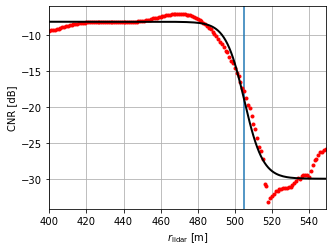

high cnr: -8.133507278433605, low_cnr: -29.980503797298205, growth_rate: 0.19891362652575575
Azimut Angle: 234.662° and estimated distance: 505.087954191345 m


In [6]:
A,D = distance_to_water(df_lidar_example[df_lidar_example.azi == df_lidar_example.azi.unique()[80]],-18,show_plot=1) # use this to show the estimation for just one azimut angle
# A,D = distance_to_water(df_lidar_example,-18,show_plot=1)  # use this to show the estimation for every azimut angle

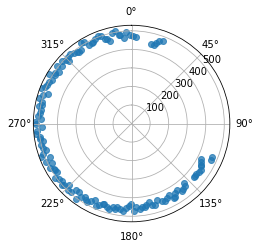

In [7]:
A,D = distance_to_water(df_lidar_example,-18)
fig,ax= plt.subplots(1,1,subplot_kw=dict(polar=True),figsize=(12/2.54,9/2.53))
ax.scatter(A/180*np.pi,D, cmap='hsv', alpha=0.75)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlabel_position(50)
fig.tight_layout()


### 2.2 Model intersection of lidar with sea surface
The mathematical model is:

In [9]:
M_x = lambda x: sp.Matrix([[1,0,0],[0, sp.cos(x),sp.sin(x)],[0,-sp.sin(x),sp.cos(x)]])
M_y = lambda x: sp.Matrix([[sp.cos(x),0,-sp.sin(x)],[0,1,0],[sp.sin(x),0,sp.cos(x)]])
M_z = lambda x: sp.Matrix([ [sp.cos(x) ,sp.sin(x) ,0 ],[-sp.sin(x) ,sp.cos(x) ,0 ],[ 0, 0, 1]])
alpha = sp.Symbol('alpha')
display(M_x(alpha))
display(M_y(alpha))
display(M_z(alpha))

Matrix([
[1,           0,          0],
[0,  cos(alpha), sin(alpha)],
[0, -sin(alpha), cos(alpha)]])

Matrix([
[cos(alpha), 0, -sin(alpha)],
[         0, 1,           0],
[sin(alpha), 0,  cos(alpha)]])

Matrix([
[ cos(alpha), sin(alpha), 0],
[-sin(alpha), cos(alpha), 0],
[          0,          0, 1]])

In [10]:
def create_fit_function():
    pitch_sym, roll_sym, height_sym, ele_sym, yaw_sym, range_sym, shift_x, shift_y = sp.symbols('phi rho h varepsilon gamma r s_x s_y')
    M_x = lambda x: sp.Matrix([[1,0,0],[0, sp.cos(x),sp.sin(x)],[0,-sp.sin(x),sp.cos(x)]])
    M_y = lambda x: sp.Matrix([[sp.cos(x),0,-sp.sin(x)],[0,1,0],[sp.sin(x),0,sp.cos(x)]])
    M_z = lambda x: sp.Matrix([ [sp.cos(x) ,sp.sin(x) ,0 ],[-sp.sin(x) ,sp.cos(x) ,0 ],[ 0, 0, 1]])
    laser_beam = lambda x: sp.Matrix([[0],[x],[0]])
    Pitch = M_x(pitch_sym)
    Roll = M_y(roll_sym)
    Yaw = M_z(yaw_sym)
    Ele = M_x(-ele_sym)
    Laser_beam = laser_beam(range_sym)
    Shift = sp.Matrix([[shift_x],[shift_y],[0]])
    Height = sp.Matrix([[0],[0],[height_sym]])
    lidar = Height + Pitch * Roll* Yaw * (Ele * Laser_beam + Shift )
    
    display(0)
    print('=')
    display(lidar[2])
    result = sp.solve(lidar[2],range_sym)
    print('')
    display(range_sym)
    print('=')
    display(result[0])
    return
create_fit_function()

0

=


h + r*sin(varepsilon)*cos(phi)*cos(rho) + s_x*(sin(gamma)*sin(phi) + sin(rho)*cos(gamma)*cos(phi)) + (r*cos(varepsilon) + s_y)*(sin(gamma)*sin(rho)*cos(phi) - sin(phi)*cos(gamma))

r

=


(h + s_x*sin(gamma)*sin(phi) + s_x*sin(rho)*cos(gamma)*cos(phi) + s_y*sin(gamma)*sin(rho)*cos(phi) - s_y*sin(phi)*cos(gamma))/(-sin(gamma)*sin(rho)*cos(phi)*cos(varepsilon) + sin(phi)*cos(gamma)*cos(varepsilon) - sin(varepsilon)*cos(phi)*cos(rho))

In [11]:
def fit_function(pitch, roll, height, ele, yaw):
    return (
        height -
        0.15*np.sin(yaw/180*np.pi)*np.sin(pitch/180*np.pi)-
        0.15*np.sin(roll/180*np.pi)*np.cos(yaw/180*np.pi)*np.cos(pitch/180*np.pi)+
        0.15*np.sin(yaw/180*np.pi)*np.sin(roll/180*np.pi)*np.cos(pitch/180*np.pi)-
        0.15*np.sin(pitch/180*np.pi)*np.cos(yaw/180*np.pi)
    )/(
        np.cos(ele/180*np.pi)*
        (
            np.cos(yaw/180*np.pi)*np.sin(pitch/180*np.pi)-
            np.cos(pitch/180*np.pi)*np.sin(roll/180*np.pi)*np.sin(yaw/180*np.pi)        
        )-
        np.cos(pitch/180*np.pi)*np.cos(roll/180*np.pi)*np.sin(ele/180*np.pi)
    )

#### 2.2.1 Example for modelled intersection
Here is an examplary sea surface intersection with a pitch angle of 0.1 Degree at a height of 25 m and an elevation of -3 Degree. Such a small misalignment leads to quite big differences in the distances, opposed to a perfectly alignd device which yields a perfect circle.

(0.0, 360.0)

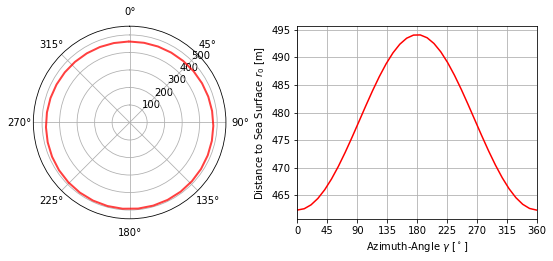

In [13]:
yaw=np.linspace(start=0,stop=359,num=36)
D = fit_function(pitch=0.1,roll=0,height=25,ele=-3,yaw=yaw)

fig = plt.figure(figsize =(24/2.54,9/2.54))
# left figure
ax1 = plt.subplot(121, projection='polar')
ax1.grid(True)
ax1.plot(yaw/180*np.pi,D,'r', alpha=0.75,linewidth=2,label=r'$r_0$' )
ax1.set_theta_zero_location("N")
ax1.set_theta_direction(-1)
ax1.set_rlabel_position(45)
ax1.set_ylim(0,550)
# right figure
ax2 = plt.subplot(122)
ax2.plot(yaw,D,'r',label=r'$r_0$')
ax2.grid(True)
ax2.set_xlabel('Azimuth-Angle $\gamma\ [^\circ]$')
ax2.set_ylabel('Distance to Sea Surface $r_0\ [\mathrm{m}]$')
ax2.set_xticks(np.arange(0,361,step=45))
ax2.set_xlim(0,360)


### 2.3 Fit Model to Estimate (SSL function)
Here we use an optimization to find the best parameters (pitch, roll and height) which reflect the measured distances best
- lorentz optimization for better outlier tolerance

In [14]:
def lidar_alignment(data,minimum_cnr,approx_height_above_nn):
    Azi,Distance = distance_to_water(data,minimum_cnr)
    start_time = data.index.min()
    if all(data.ele>-3.01) and all(data.ele<-2.99) and len(Azi)>20:
        ele = -3
    else:
        return np.nan, np.nan, np.nan, np.nan,np.nan, np.nan
    
    x0 = [0,0,approx_height_above_nn]
#     method = 'least-squares'
    method = 'lorentz'
    if method == 'lorentz':
        Cost = lambda x: np.sum(
            np.log(
                1+0.5*(
                    Distance - fit_function(pitch=x[0],roll=x[1],height=x[2],ele=ele,yaw=Azi)
                )**2
            )
        )
    elif method == 'least-squares':
        Cost = lambda x: np.sum(
            (
                Distance - fit_function(pitch=x[0],roll=x[1],height=x[2],ele=ele,yaw=Azi)
            )**2
        )   
    res = minimize(Cost, x0, method='nelder-mead',options={'xatol': 1e-8, 'disp': False})
    p,r,h = res.x
    return p,r,h,Azi,Distance, start_time
        

#### 2.3.1 Example for SSL on  exemplary Lidar Scan
Here we apply the optimization to the example data, together with the distance_to_water to compare the model results to the measured water distances.

-0.034234773554786144 -0.20599689693051043 24.396504475562985


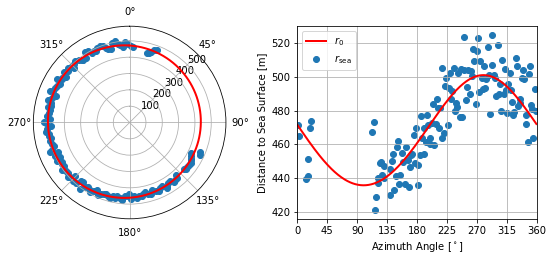

In [15]:
p,r,h,Azi,Distance, start_time=lidar_alignment(df_lidar_example,-18,25)
Azi,Distance = distance_to_water(df_lidar_example,-18)

fig = plt.figure(figsize=(24/2.54,9/2.54))
ax1 = plt.subplot(121,projection='polar')
ax1.scatter(Azi/180*np.pi,Distance)
ax1.set_theta_zero_location("N")
ax1.set_theta_direction(-1)
ax1.set_rlabel_position(45)
ax1.plot(np.arange(0,360)/180*np.pi,fit_function(p,r,h,-3,np.arange(0,360)),'r',linewidth=2)
ax1.grid(True)
ax1.set_ylim(0,590)

ax2 = plt.subplot(122)
ax2.scatter(Azi,Distance,label=r'$r_\mathrm{sea}$')
ax2.plot(np.arange(0,360),fit_function(p,r,h,-3,np.arange(0,360)),'r',linewidth=2,label=r'$r_0$')
ax2.grid(True)
ax2.set_xlabel('Azimuth Angle $[^\circ]$')
ax2.set_xticks(np.arange(0,361,step=45))
ax2.set_ylabel('Distance to Sea Surface [m]')
ax2.set_xlim(0,360)
ax2.legend()
print(p,r,h)

## 3. Apply SSL to Lidar Data
Here the lidar alignment is applied on the whole data set. This means for each SSL scan the Fit-model is applied to estimate the leveling, for this the distances for every azimut angle in every scan needs to be estimated. Depending on the number of scans this can take several hours. For this reason, we have saved the results in a df_results_SSL.zip file to faster progress through the code. <br>
The variable [do_the_calculation] lets you recalculate the results and overwrites the df_results_SSL.zip file with the new results. 

In [16]:
do_the_calculation = False  # The calculation takes several hours. So the results are pre calculated in a zip file.
if do_the_calculation:
    P = np.array([])
    R = np.array([])
    H = np.array([])
    T = np.array([])
    df_results_SSL = pd.DataFrame()
    for scan_nr in tqdm(df_lidar.scan_nr.unique()):
        idx = (df_lidar.scan_nr == scan_nr)
        p,r,h,Azi,Distance, t=lidar_alignment(df_lidar[idx],-18,25)
        if any([np.isnan(p),np.isnan(r),np.isnan(h)]):
            continue
        else:
            P = np.append(P,p)
            R = np.append(R,r)
            H = np.append(H,h)
            T = np.append(T,t)
    df_results_SSL = pd.DataFrame({'pitch':P,'roll':R,'height':H},index=T)
    df_results_SSL.to_pickle('data\\df_results_SSL.zip')
else:
    df_results_SSL = pd.read_pickle('data\\df_results_SSL.zip')
len(df_results_SSL)

1930

### 3.1 Compare heights with measurements from BSH

Jörge hat die Daten vom BSH für den Zeitraum im Mai angefragt und wir haben sie erhalten. Ich lade die Daten in der nächsten Zelle ein und vergleiche sie mit unserem Messungen

In [17]:
ssh = pd.read_csv('data\\ssh_global_tech1.txt',sep='\s+', header=None,names=['date','ssh'])
ssh.set_index(pd.to_datetime(ssh.date,format='%Y%m%d%H%M'),inplace=True)
ssh.drop(['date'],axis=1,inplace=True)
df_results_SSL = df_results_SSL.join(ssh,how='outer')
cost = lambda x: np.sum((df_results_SSL.height.resample('1h').mean() + df_results_SSL.ssh.resample('1h').mean()-x)**2)
opt_height_diff = minimize(cost,0)
opt_h = opt_height_diff.x
print('height above sea surface: {:.2f} m'.format(opt_h[0]))
df_results_SSL.ssh[pd.notna(df_results_SSL.ssh)] = opt_h - df_results_SSL.ssh[pd.notna(df_results_SSL.ssh)]


height above sea surface: 24.83 m


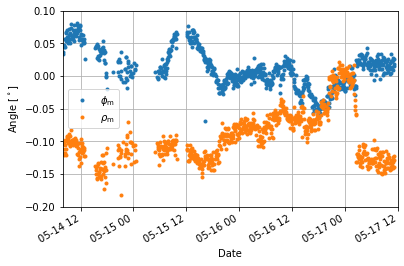

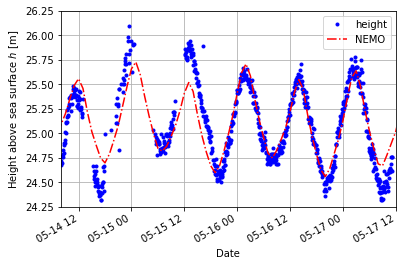

In [22]:
ax1 = df_results_SSL['pitch'].plot(style='.',label=r'$\phi_\mathrm{m}$',legend=True, grid=True)
df_results_SSL['roll'].plot(style='.',label=r'$\rho_\mathrm{m}$',legend=True, grid=True)
start_time = pd.Timestamp('2019-05-14 08:00')
end_time = pd.Timestamp('2019-05-17 12:00')
ax1.set_xlim(start_time, end_time)
ax1.set_ylim(-0.2, 0.1)
ax1.set_ylabel('Angle $[^\circ]$')
ax1.set_xlabel('Date')
plt.show()

ax2 = df_results_SSL['height'].plot(style='.',c='b', legend=True,grid=True)
df_results_SSL['ssh'][pd.notna(df_results_SSL['ssh'])].plot(style='-.',c='r',legend=True,label='NEMO',zorder=2,grid=True)
ax2.set_xlim(start_time, end_time)
ax2.set_ylim(24.25,26.25)
ax2.set_ylabel('Height above sea surface $h$ [m]')
ax2.set_xlabel('Date')
plt.show()


## 4. Thrust model
wir haben folgende bekannten Variablen $\phi_\mathrm{m}$ den gemessenen pitch-Winkel, $\rho_\mathrm{m}$ der gemessenen roll-Winkel. Dazu haben wir die folgenden unbekannten Variablen $\phi_\mathrm{r}$ der pitch Winkel in Ruhe lage, $\rho_\mathrm{r}$ der roll-Winkel in Ruhelage und der Tilt Winkel $\tau$, welcher aus einem Modell in Abhängigkeit zum Schub der Anlage bestimmt werden soll.

In [23]:
pitch_m, roll_m, pitch_r, roll_r, tilt, yaw = sp.symbols('phi_m rho_m phi_r rho_r tau gamma')

Pitch_m = M_x(pitch_m)
Roll_m = M_y(roll_m)
Pitch_r = M_x(pitch_r)
Roll_r = M_y(roll_r)
Tilt = M_z(yaw)*M_x(-tilt)*M_z(-yaw)

Left = Pitch_m*Roll_m*sp.Matrix([[0],[0],[1]])
Right = Tilt*Pitch_r*-Roll_r*sp.Matrix([[0],[0],[1]])

display(Left-Right)

Matrix([
[           ((sin(gamma)*cos(gamma)*cos(tau) - sin(gamma)*cos(gamma))*sin(phi_r) - sin(gamma)*sin(tau)*cos(phi_r))*cos(rho_r) - (sin(gamma)**2*cos(tau) + cos(gamma)**2)*sin(rho_r) - sin(rho_m)],
[((sin(gamma)**2 + cos(gamma)**2*cos(tau))*sin(phi_r) - sin(tau)*cos(gamma)*cos(phi_r))*cos(rho_r) - (sin(gamma)*cos(gamma)*cos(tau) - sin(gamma)*cos(gamma))*sin(rho_r) + sin(phi_m)*cos(rho_m)],
[                                                                     (sin(phi_r)*sin(tau)*cos(gamma) + cos(phi_r)*cos(tau))*cos(rho_r) - sin(gamma)*sin(rho_r)*sin(tau) + cos(phi_m)*cos(rho_m)]])

In [25]:
M_x(pitch_m)*M_y(roll_m)*sp.Matrix([[0],[0],[1]])

Matrix([
[          -sin(rho_m)],
[sin(phi_m)*cos(rho_m)],
[cos(phi_m)*cos(rho_m)]])

Der tilt wurde umgewandelt in einen lot vektor. Aus diesem kann dann wieder pitch und roll berechnet werden.
Es gilt:
$$
\begin{pmatrix}
x\\
y\\
z\\
\end{pmatrix}=
M_x(\phi)\cdot M_y(\rho) \cdot 
\begin{pmatrix} 
0 \\
0 \\
1 
\end{pmatrix}=
\begin{pmatrix} 
-\sin(\rho)\\
\cos(\rho)\sin(\phi)\\
\cos(\rho)\cos(\phi)
\end{pmatrix}
$$

Daraus kann man also umgekehrt:
$\rho = \arcsin(-x)$ und $\phi = \arcsin\left(\frac{y}{\cos(\rho)}\right)$


### 4.1 Apply thrust model to SSL results
Estimate resting pitch and roll and lin scaling factor

In [26]:
df = df_scada.join(df_results_SSL)
df = df.resample('5min').mean()
df = df[~df['pitch'].isna()]
df.reset_index(inplace=True)
df.loc[:,'PitchB1'] = df.loc[:,'PitchB1'].ffill()

In [27]:
M_x = lambda x: np.array([[1,0,0],[0, np.cos(x/180*np.pi),np.sin(x/180*np.pi)],[0,-np.sin(x/180*np.pi),np.cos(x/180*np.pi)]],dtype="object")
M_y = lambda x: np.array([[np.cos(x/180*np.pi),0,-np.sin(x/180*np.pi)],[0,1,0],[np.sin(x/180*np.pi),0,np.cos(x/180*np.pi)]],dtype="object")
M_z = lambda x: np.array([ [np.cos(x/180*np.pi) ,np.sin(x/180*np.pi) ,0 ],[-np.sin(x/180*np.pi) ,np.cos(x/180*np.pi) ,0 ],[ 0, 0, 1]],dtype="object")

In [28]:
pitch_m = np.array(df['pitch'])
roll_m = np.array(df['roll'])
u = np.array(df['WSpd'])
p = np.array(df['P'])
yaw = np.array(df['NacPos'])

thrust = lambda power, wspd: np.where(power/wspd>0,power/wspd,0)

x0 = [0,0,0] 

cost = lambda x: np.linalg.norm(
    np.linalg.norm(
        M_z(yaw)@M_x(-x[0]*thrust(p,u))@M_z(-yaw)@M_x(x[1])@M_y(x[2])-M_x(pitch_m)@M_y(roll_m)
    ).squeeze()
)

result_opt = minimize(cost,np.array(x0),method='Nelder-Mead')

In [29]:
result_opt

 final_simplex: (array([[ 1.85417296,  0.02580108, -0.11284461],
       [ 1.85423953,  0.02580327, -0.11284274],
       [ 1.85418547,  0.02579989, -0.11284318],
       [ 1.85410942,  0.02580087, -0.11284318]]), array([0.02397691, 0.02397691, 0.02397691, 0.02397691]))
           fun: 0.023976913551164117
       message: 'Optimization terminated successfully.'
          nfev: 283
           nit: 158
        status: 0
       success: True
             x: array([ 1.85417296,  0.02580108, -0.11284461])

In [30]:
a, pitch_r, roll_r  = result_opt.x

### 4.2 Calculate tilt angle from thrust model

In [31]:
df['tilt']=a*thrust(p,u)

### 4.3 Calculate tilt angle from SSL measurements

In [32]:
pitch_measured = np.array(df['pitch'])
roll_measured = np.array(df['roll'])
yaw_turbine = np.array(df['NacPos'])
pitch_rest = pitch_r
roll_rest = roll_r
x0 = 0
res_array=[]
for p,r,y in zip(pitch_measured, roll_measured,yaw_turbine):
    cost = lambda x: np.linalg.norm(
    np.linalg.norm(
        M_x(p)@M_y(r)-M_z(y)@M_x(-x)@M_z(-y)@M_x(pitch_rest)@M_y(roll_rest)
    ).squeeze()
    )
    result_opt_test = minimize(cost,0.14,method='Nelder-Mead')
    res_array.append(result_opt_test.x)
res_array = np.stack(res_array)
df['tilt_measured']=res_array

### 4.4 Compare tilt angles from thrust model and from SSL

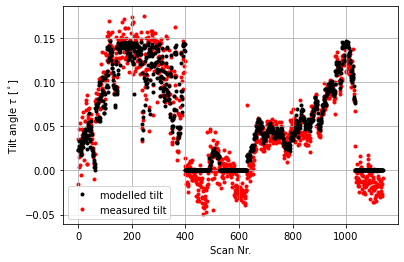

In [50]:
ax = df['tilt'].plot(grid=True,c='k', style='.',label='modelled tilt',legend=True,zorder=2)
ax=df['tilt_measured'].plot(c='r',style='.',grid=True,label='measured tilt',legend=True, zorder=1)
ax.set_xlabel('Scan Nr.')
ax.set_ylabel(r'Tilt angle $\tau\ [^\circ]$')
plt.show()

In [34]:
from scipy.odr import *
from scipy.stats import linregress
def linear_func(p,x):
    m,c=p
    return m*x+c
linear_model = Model(linear_func)
data = RealData(np.array(df['P']/df['WSpd']),np.array(df['tilt_measured']))
odr = ODR(data,linear_model, beta0=[0.,1.])
out = odr.run()
out.pprint()

slope, intercept, r, p, se = linregress(np.array(df['P']/df['WSpd']),np.array(df['tilt_measured']))
print(slope,intercept)

Beta: [ 2.11165082 -0.01000486]
Beta Std Error: [0.02011425 0.00081163]
Beta Covariance: [[ 6.89196997 -0.21035075]
 [-0.21035075  0.01122144]]
Residual Variance: 5.8703540988277e-05
Inverse Condition #: 0.0026382877940667477
Reason(s) for Halting:
  Sum of squares convergence
1.9454464088927474 -0.0049321155545051995


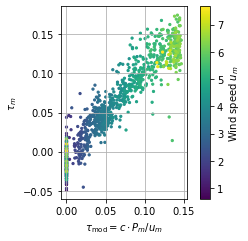

In [38]:
plt.figure(figsize=(12/2.54,9/2.54))
plt.scatter(df.sort_values(by=['WSpd'])['tilt'],df.sort_values(by=['WSpd'])['tilt_measured'],s=5,c=df.sort_values(by=['WSpd'])['WSpd'])
plt.xlabel(r'$\tau_{\mathrm{mod}} =c\cdot P_m / u_m$')
plt.ylabel(r'$\tau_m$')
plt.colorbar(label='Wind speed $u_m$')
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal')


### 4.5 Calculate modelled roll and pitch from thrust model

In [39]:
yaw = np.array(df['NacPos'])
tilt = np.array(df['tilt'])
X = M_z(yaw)@M_x(-tilt)@M_z(-yaw)@M_x(pitch_r)@M_y(roll_r)@np.matrix([[0],[0],[1]])

x = X[0,0].squeeze()
y = X[1,0].squeeze()
z = X[2,0].squeeze()

roll_mod = np.arcsin(-x)
pitch_mod = np.arcsin(y/np.cos(roll_mod))

df['roll_mod']=roll_mod/np.pi*180
df['pitch_mod']=pitch_mod/np.pi*180

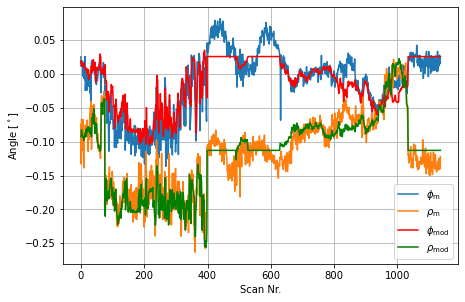

In [41]:
ax = df['pitch'].plot(grid=True, label=r'$\phi_\mathrm{m}$', legend=True,figsize=(18/2.54,12/2.54))
df['roll'].plot(grid=True, label=r'$\rho_\mathrm{m}$', legend=True)
(df['pitch_mod']).plot(grid=True,c='r', label='$\phi_\mathrm{mod}$', legend=True)
(df['roll_mod']).plot(grid=True,c='g', label=r'$\rho_\mathrm{mod}$', legend=True)
ax.set_xlabel('Scan Nr.')
ax.set_ylabel('Angle $[^\circ]$')
plt.show()

## 5. Evaluate Results

In [42]:
def rmse(input):
    return ((input**2).mean())**0.5

In [43]:
print('ROLL')
temp = df['roll']-df['roll_mod']
print(temp.describe())
print('rmse: ' +  str(rmse(df['roll']-df['roll_mod'])))
print('PITCH')
temp = df['pitch']-df['pitch_mod']
print(temp.describe())
print('rmse' + str(rmse(df['pitch']-df['pitch_mod'])))

ROLL
count    1137.000000
mean        0.000001
std         0.019279
min        -0.080147
25%        -0.012605
50%         0.000470
75%         0.012102
max         0.124606
dtype: float64
rmse: 0.01927004647465774
PITCH
count    1.137000e+03
mean     7.366210e-07
std      2.142424e-02
min     -9.375371e-02
25%     -1.182373e-02
50%     -6.137043e-04
75%      1.219341e-02
max      5.814154e-02
dtype: float64
rmse0.021414820443588736


## 6. Extra: Alternative Methode based on vectorial calculation

In [44]:
df['Thrust_NS']=-np.cos(df['NacPos']/180*np.pi)*thrust(df['P'],df['WSpd'])
df['Thrust_WE']=-np.sin(df['NacPos']/180*np.pi)*thrust(df['P'],df['WSpd'])

In [45]:
cost = lambda x: np.sum(
    (np.array(df['pitch'])-np.array(x[1]+x[0]*df['Thrust_NS']))**2
)+np.sum(
    (np.array(df['roll'])-np.array(x[2]-x[0]*df['Thrust_WE']))**2
)

result_opt_vec = minimize(cost,[0,0,0],method='Nelder-Mead')
print(result_opt_vec)

 final_simplex: (array([[ 1.85417296,  0.02580108, -0.11284461],
       [ 1.85423953,  0.02580327, -0.11284274],
       [ 1.85418547,  0.02579989, -0.11284318],
       [ 1.85410942,  0.02580087, -0.11284318]]), array([0.94363005, 0.94363005, 0.94363005, 0.94363006]))
           fun: 0.9436300502205982
       message: 'Optimization terminated successfully.'
          nfev: 283
           nit: 158
        status: 0
       success: True
             x: array([ 1.85417296,  0.02580108, -0.11284461])


In [46]:
df['pitch_mod']=result_opt_vec.x[1]+result_opt_vec.x[0]*df['Thrust_NS']
df['roll_mod']=result_opt_vec.x[2]-result_opt_vec.x[0]*df['Thrust_WE']

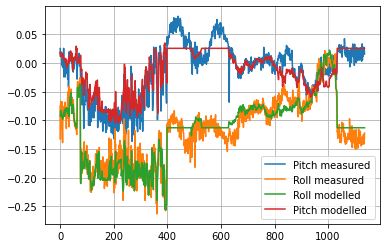

In [48]:
ax=df['pitch'].plot(label='Pitch measured',legend=True,grid=True)
df['roll'].plot(label='Roll measured',legend=True,grid=True)
df['roll_mod'].plot(label='Roll modelled',legend=True,grid=True)
df['pitch_mod'].plot(label='Pitch modelled',legend=True,grid=True)
plt.show()

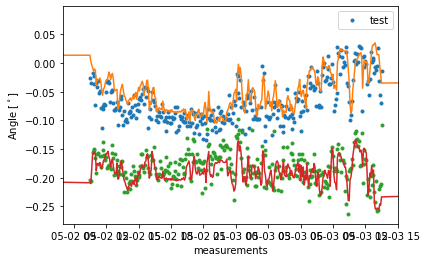

In [49]:
fig, ax  = plt.subplots()

start_time = pd.Timestamp('2019-05-02 08:00')
end_time = pd.Timestamp('2019-05-03 15:00')
ax.plot(df['index'],df['pitch'],'.')
ax.plot(df['index'],df['pitch_mod'])
ax.plot(df['index'],df['roll'],'.')
ax.plot(df['index'],df['roll_mod'])
ax.set_xlabel('measurements')
ax.set_ylabel('Angle $[^\circ]$')
ax.legend(['test'])
ax.set_xlim(start_time, end_time)
plt.show()